In [1]:
import numpy as np
from scipy.stats import poisson, norm
import matplotlib.pyplot as plt
import time

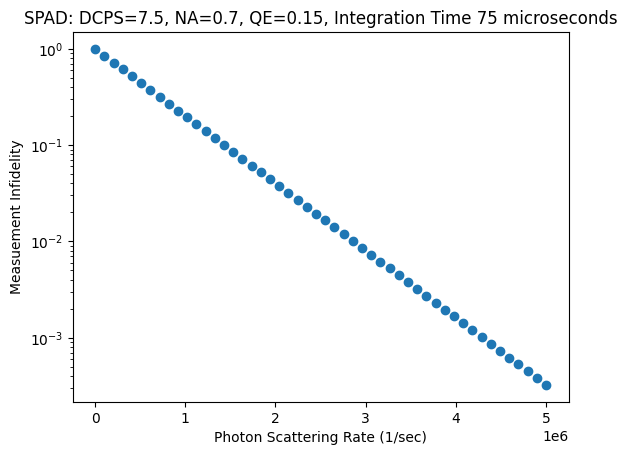

In [32]:
darkCountsPerSecond = 7.5
NA = 0.7
QE = 0.15
integrationTimeMicros = 75
integrationTimeSeconds = integrationTimeMicros*1e-6
def spaderrorandthreshold(photonsScatteredPerSecond):
    signalCountsPerSecond = photonsScatteredPerSecond*QE*(1-np.sqrt(1-NA**2))/2
    ldark = integrationTimeSeconds*darkCountsPerSecond
    latom = ldark+integrationTimeSeconds*signalCountsPerSecond
    besterror = 1
    bestthreshold = 1
    threshold=bestthreshold
    while(True):
        error = poisson.cdf(threshold-1, latom) + poisson.sf(threshold, ldark)
        if error < besterror:
            besterror = error
            bestthreshold = threshold
            threshold+=1
        else:
            break
    return besterror, bestthreshold
xs = np.linspace(0, 5*10**6, 50)
errors, thresholds = zip(*[spaderrorandthreshold(x) for x in xs])

plt.scatter(xs, errors)
plt.yscale('log')
plt.xlabel('Photon Scattering Rate (1/sec)') 
plt.ylabel('Measuement Infidelity')
plt.title(f'SPAD: DCPS={darkCountsPerSecond}, NA={NA}, QE={QE}, Integration Time {integrationTimeMicros} microseconds')
plt.show() 

17.91463829999998


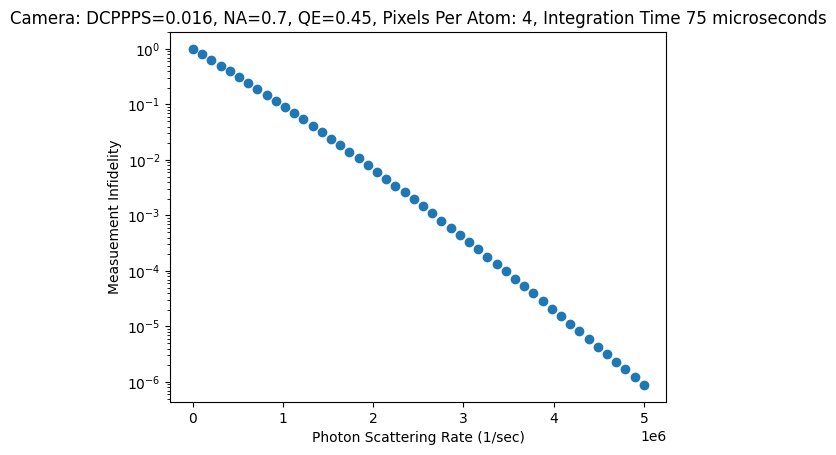

In [33]:
# Unweighted Square ROI scattering rate analysis
darkCountsPerPixelPerSecond = 0.016    # dark photoelectroncs per pixel per second
NA = 0.7
QE = 0.45
readoutSigma = 0.4             # readout photoelectron standard deviation per pixel
integrationTimeMicros = 75
integrationTimeSeconds = integrationTimeMicros*1e-6
ADUConversion = 1/0.106       # Conversion factor to translate from photoelectrons to camera counts, which the threshold is actually measured in
percentileCutoff = 10**-16    # Poisson distributions are summed over inner [cuttoff, 1-cuttoff] percentiles
numpixels = 4                # number of pixels on the camera each atom is mapped to
def cameraerrorandthreshold(photonsScatteredPerSecond):
    #print(photonsScatteredPerSecond)
    signalCountsPerSecond = photonsScatteredPerSecond*QE*(1-np.sqrt(1-NA**2))/2  # This might need a fill factor correction for numpixels>1
    ldark = integrationTimeSeconds*darkCountsPerPixelPerSecond*numpixels
    latom = ldark+integrationTimeSeconds*signalCountsPerSecond
    besterror = 1
    bestthreshold = int(np.ceil(ldark*ADUConversion)) # Optimal threshold must be at least as high as the EV of dark counts
    threshold=bestthreshold

    # Sum limits to cut off the infinite discrete sum from the Poisson distributions
    # Sum endpoints will be determined by the tails of the Poisson distribution
    atomlower =  int(np.floor(poisson.ppf(percentileCutoff, latom)))
    atomupper =  int(np.ceil(poisson.ppf(1-percentileCutoff, latom))) +1
    darklower =  int(np.floor(poisson.ppf(percentileCutoff, ldark)))
    darkupper =  int(np.ceil(poisson.ppf(1-percentileCutoff, ldark))) +1
    
    while(True):
        error = 0
        # Probability that sum of atom photon counts and readout noise comes out to less than threshold
        for i in range(atomlower, atomupper):
            error  += poisson.pmf(i, latom)*norm.cdf(threshold-i*ADUConversion, scale=ADUConversion*readoutSigma*np.sqrt(numpixels))
        # Probability that the sum of dark photon counts and readout noise at least equals threshold
        for i in range(darklower, darkupper):
            error +=  poisson.pmf(i, ldark)*norm.sf(threshold-i*ADUConversion, scale=ADUConversion*readoutSigma*np.sqrt(numpixels))
        if error < besterror:
            besterror = error
            bestthreshold = threshold
            threshold+=1
        else:
            break
    return besterror, bestthreshold
xs = np.linspace(1, 5*10**6, 50)
tic = time.perf_counter()
errors, thresholds = zip(*[cameraerrorandthreshold(x) for x in xs])
print(time.perf_counter()-tic)
plt.scatter(xs, errors)
plt.yscale('log')
plt.xlabel('Photon Scattering Rate (1/sec)') 
plt.ylabel('Measuement Infidelity')
plt.title(f'Camera: DCPPPS={darkCountsPerPixelPerSecond}, NA={NA}, QE={QE}, Pixels Per Atom: {numpixels}, Integration Time {integrationTimeMicros} microseconds')
plt.show() 